`shutup.please()` suppresses all warnings from libraries like `matplotlib, numpy, osmnx, etc.`
It’s basically a wrapper around this:
```
import warnings
warnings.filterwarnings("ignore")
```

In [26]:
import shutup
shutup.please()

<ul> <li><code>import networkx as nx</code> – Provides tools for creating and analyzing complex graphs and networks using standard graph theory algorithms.</li> <li><code>import hypernetx as hnx</code> – Enables working with hypergraphs, where relationships (edges) can connect more than two nodes.</li> <li><code>import osmnx as ox</code> – Downloads and analyzes street networks and geospatial data from OpenStreetMap.</li> <li><code>import folium</code> – Builds interactive Leaflet maps directly in Python, perfect for visualizing geographic data.</li> </ul>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

import networkx as nx
import osmnx as ox
import folium

First, we geocode two famous locations in Sofia:
- the <b>Levski Monument</b> and the <b>Sedmochislenitsi Church</b>.
- The `ox.geocode()` function connects to OpenStreetMap and returns the latitude and longitude of these addresses.

In [28]:
start_point_name = "Pametnik Vasil Levski, Sofia, Bulgaria"
end_point_name = "Sveti Sedmochislenitsi Church, Sofia, Bulgaria"

start_point_geocode = ox.geocode(start_point_name)
end_point_geocode = ox.geocode(end_point_name)

In [32]:
start_point_geocode, end_point_geocode

((42.696665, 23.3353291), (42.6899482, 23.327621))

In [33]:
f'from {start_point_geocode[0]}, {start_point_geocode[1]} to {end_point_geocode[0]}, {end_point_geocode[1]}'

'from 42.696665, 23.3353291 to 42.6899482, 23.327621'

<li>Next, we generate a street network graph around the Levski Monument. For that we would need the `center_point`!</li>

<li>The `graph_from_point` function downloads all drivable roads within 1500 meters of the location. It builds a graph where intersections are nodes and streets are edges.</li>

In [31]:
center_point = (
    (start_point_geocode[0] + end_point_geocode[0]) / 2,
    (start_point_geocode[1] + end_point_geocode[1]) / 2
)

In [35]:
graph = ox.graph_from_point(center_point, dist=1000, network_type='drive')

Let's plot the GRAPH!

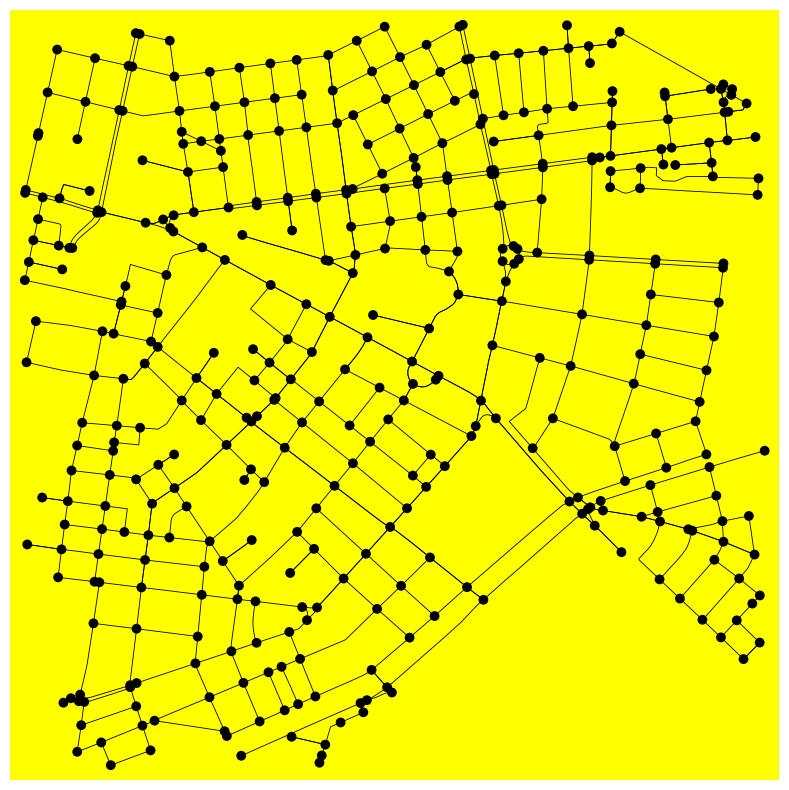

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [48]:
ox.plot_graph(
    graph,
    bgcolor='yellow',
    edge_color='black',
    node_color = 'black',
    edge_linewidth=0.6,
    node_size=50,
    figsize=(10, 10)
)

Now, we find the nearest nodes in the graph to our two geocoded points.
These are the actual nodes we'll use for our path calculation.


In [37]:
origin_node = ox.distance.nearest_nodes(graph, start_point_geocode[1], start_point_geocode[0])
destination_node = ox.distance.nearest_nodes(graph, end_point_geocode[1], end_point_geocode[0])

LET'S PLOT THE ORIGIN AND THE DESTINATION!

In [56]:
destination_xy

(23.328259, 42.689964)

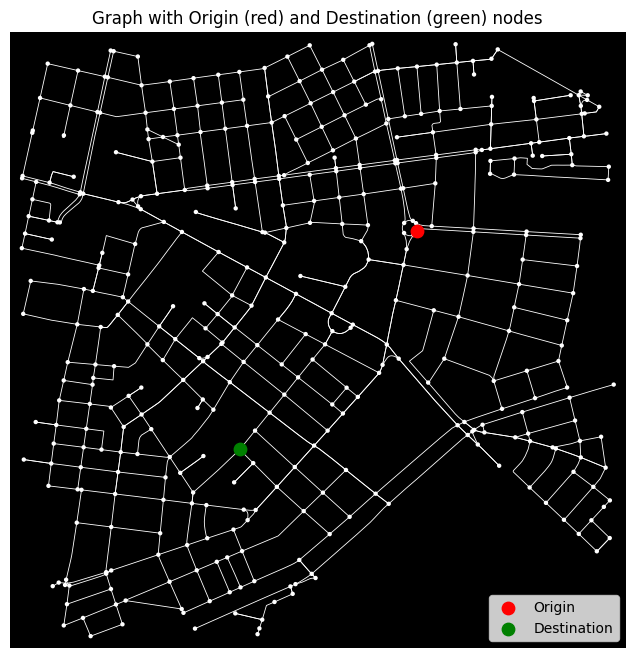

In [62]:
fig, ax = ox.plot_graph(
    graph,
    bgcolor="black",
    edge_color="white",
    edge_linewidth=0.6,
    node_size=10,
    show=False,
    close=False
)

# Get (x, y) coordinates of the nodes
origin_xy = (graph.nodes[origin_node]['x'], graph.nodes[origin_node]['y'])
destination_xy = (graph.nodes[destination_node]['x'], graph.nodes[destination_node]['y'])

# Plot origin (in red) and destination (in lime)
ax.scatter(*origin_xy, s=80, c='red', label='Origin', zorder=3)
ax.scatter(*destination_xy, s=80, c='green', label='Destination', zorder=3)

# Optional: add legend and title
ax.legend(facecolor='white')
plt.title("Graph with Origin (red) and Destination (green) nodes")
plt.show()


We then use NetworkX's `shortest_path()` function, which finds the shortest path based on distance — using Dijkstra’s algorithm under the hood.

In [64]:
route = nx.shortest_path(graph, origin_node, destination_node, weight='length', method='dijkstra')
route_length_m = nx.shortest_path_length(graph, origin_node, destination_node, weight='length', method='dijkstra')
print(f"Shortest road distance: {route_length_m/1000:.2f} km")

Shortest road distance: 1.68 km


Let's PLOT the route!

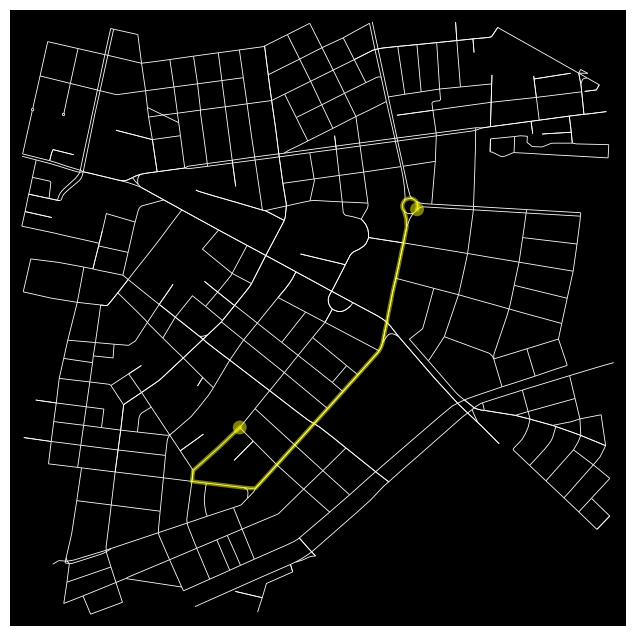

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [65]:
ox.plot_graph_route(graph, route, bgcolor='black', edge_color='white', route_color='yellow', node_size=0, edge_linewidth=0.6, route_linewidth=3)

Here, we create an interactive Folium map to visualize everything.
We calculate the midpoint between the two locations and center the map there.

Red shows the start location, green shows the destination, and the blue marker is just the center point for reference.
Finally, we draw the shortest route between the two points in yellow, using the list of nodes returned earlier.

In [68]:
m = folium.Map(
    location=center_point,
    zoom_start=15,
    tiles='cartodbpositron',
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)


In [69]:
m

<h5>Draw all roads (edges) on the map in gray</h5>
<li>converts the graph to a GeoDataFrame of edges
<li>Iterates over each edge (street segment)
<li>Extracts the geometry (a LineString)
<li>Plots it on the Folium map as a light gray line (#888888)
    
<h5>This gives you a visual background of all the streets before plotting the shortest path.
</h5>

In [70]:
edges_gdf = ox.graph_to_gdfs(graph, nodes=False, edges=True)


In [71]:
for _, row in edges_gdf.iterrows():
    coords = [(lat, lon) for lon, lat in row['geometry'].coords]
    folium.PolyLine(coords, color='#888888', weight=1, opacity=0.5).add_to(m)


<li>Extracts the (lat, lon) coordinates of each node in the shortest route
<li>Draws a blue polyline to connect those points on the map

In [72]:
route_coords = [
    (graph.nodes[node]['y'], graph.nodes[node]['x'])
    for node in route
]

In [88]:
folium.PolyLine(route_coords, color='blue', weight=4, opacity=1.0).add_to(m)


In [81]:
folium.Marker(
    location=start_point_geocode,
    icon=folium.Icon(color='red', icon='monument', prefix='fa'),
    popup=start_point_name
).add_to(m)

folium.Marker(
    location=end_point_geocode,
    icon=folium.Icon(color='green', icon='church', prefix='fa'),
    popup=end_point_name
).add_to(m)

folium.Marker(
    location=center_point,
    icon = folium.Icon(color='yellow',icon='flag',prefix='fa'),
    popup = "<b>My blog:</b><br><a href='https://VitoshAcademy.com'>VitoshAcademy.com</a>"
).add_to(m)

In [85]:
m

This code does two main things:

<li>Downloads the street network (graph) from OpenStreetMap</li>
<li>Plots it visually with matplotlib</li>

Additionally
    
<li>Uses the address (place_name)</li>
<li>Converts it to a center coordinate using OpenStreetMap’s Nominatim geocoder</li>
<li>Downloads the street network within 2.5 km of that point</li>
<li>Restricts it to drivable roads only (because network_type='drive')</li>
<li>Stores the result in graph as a NetworkX MultiDiGraph (intersections = nodes, roads = edges)</li>

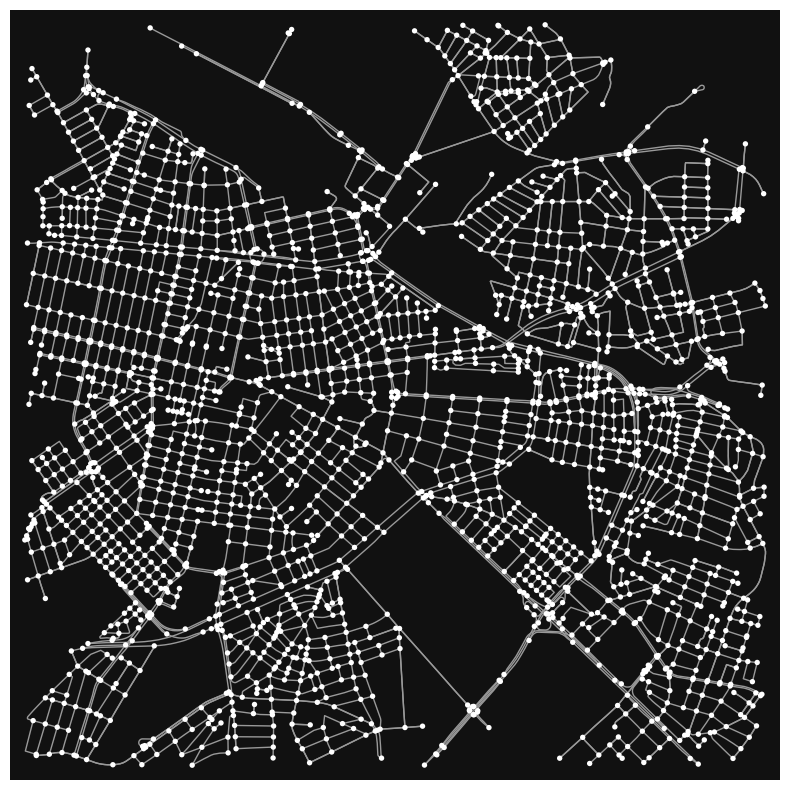

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [86]:
place_name = start_point_name
distance = 2500  # in meters

graph = ox.graph_from_address(place_name, dist=distance, network_type='drive')
ox.plot_graph(graph,figsize=(10,10))

And now for a beautiful static visualization.
We use plot_graph_route to render the full street graph.
The background is black, all roads are drawn in white, and the shortest path is highlighted in yellow.
It’s clean, minimal, and a great visual result of everything we've done.

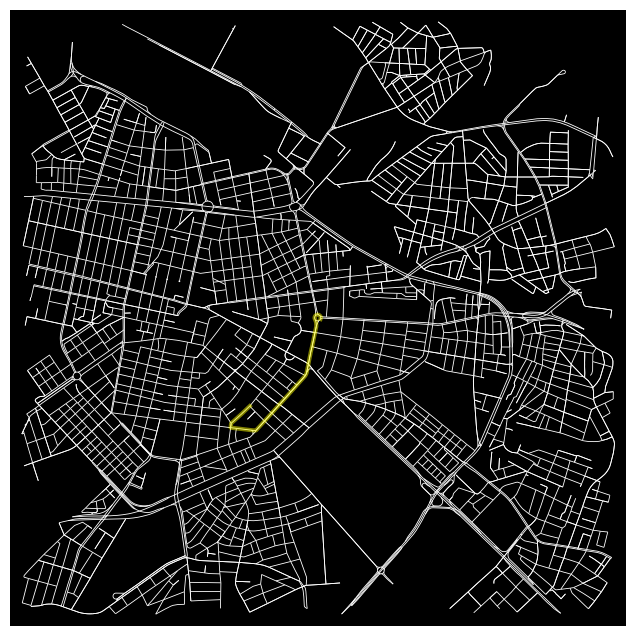

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [87]:
# Plot the graph with white roads and yellow shortest path
ox.plot_graph_route(
    graph,
    route,
    bgcolor="black",
    edge_color="white",
    edge_linewidth=0.6,
    route_color="yellow",
    route_linewidth=3,
    node_size=0,
    orig_dest_size=0       
)

And that’s how you calculate and visualize the shortest route between two real-world locations using Python, OpenStreetMap, and graph theory.
If you want to experiment more — try changing the network type to walk or bike, or use your own city.
If this was helpful, like and subscribe to VitoshAcademy for more Python, algorithms, and real-world coding.